# The Maze // Final Project of [Computer Tutorial in Markov Modeling, WS17/18](http://www.mi.fu-berlin.de/w/CompMolBio/EmmaSeminar17_18)
by Mustafa Emre Coltu, H. Altuğ Yıldırım, Kenichi Maeda, Jakob Roßbach

Another version of the same project can be found in [here](https://github.com/JlR1/markovmaze) by Jakob.

Documentation related to PyEmma project can be found in [here](http://emma-project.org/latest/).

## The Workflow

1\. Set up a maze generator.

2\. Set up the transition matrix.

3\. Estimate a markov model.

4\. Calculate the reactive flux.

## Import Libraries

In [18]:
import pyemma
import msmtools
import numpy as np
from numpy.random import random_integers as randint
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from fractions import Fraction
import warnings

## Maze Generator

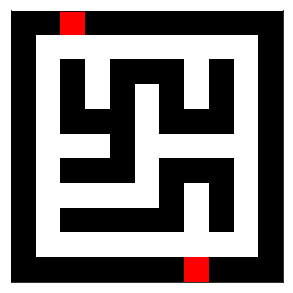

size of the maze= 11.0


In [19]:
# Beautify
warnings.filterwarnings("ignore", category=DeprecationWarning)

def maze(width=50, height=50, complexity=.75, density=.75):

    # Limit to odd dimensions
    shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)

    # Sections
    complexity = int(complexity * (5 * (shape[0] + shape[1])))
    density    = int(density * ((shape[0] // 2) * (shape[1] // 2)))

    # Fill maze with walls
    Z = np.zeros(shape, dtype=float)

    # Set borders
    Z[0, :] = Z[-1, :] = 1
    Z[:, 0] = Z[:, -1] = 1

    # Generate pathways
    for i in range(density):
        x, y = randint(0, shape[1] // 2) * 2, randint(0, shape[0] // 2) * 2
        Z[y, x] = 1
        for j in range(complexity):
            neighbours = []
            if x > 1:             neighbours.append((y, x - 2))
            if x < shape[1] - 2:  neighbours.append((y, x + 2))
            if y > 1:             neighbours.append((y - 2, x))
            if y < shape[0] - 2:  neighbours.append((y + 2, x))
            if len(neighbours):
                y_,x_ = neighbours[randint(0, len(neighbours) - 1)]
                if Z[y_, x_] == 0:
                    Z[y_, x_] = 1
                    Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                    x, y = x_, y_

    # Set start
    while True:
        x = randint(1, height - 1)
        if Z[1, x] == 0:
            Z[0, x] = 0.5
            break

    # Set exit
    while True:
        x = randint(1, width - 1)
        if Z[height - 1, x] == 0:
            Z[height, x] = 0.5
            break
    return Z

# Generate the maze
dimension = 11
if dimension == 1:
    dimension = 3
if dimension % 2 != 0:dimension -=1
width = height = dimension
Z = maze(width,height)

# Draw the maze'
cmap = mpl.colors.ListedColormap(['white', 'red', 'black'])
figureSize = 5
plt.figure(figsize=(figureSize, figureSize))
plt.imshow(Z, cmap=cmap, interpolation='none')
plt.xticks([]), plt.yticks([])
plt.show()

# Set start and exit as white
for x in range(width + 1):
    for y in range(height + 1):
        if Z[y, x] == 0.5: Z[y, x] = 0
M=Z
print("size of the maze=", np.sqrt(M.size))
a=np.sqrt(M.size)
width = height = a.astype(np.int64)

## Creating the Transition Matrix

* ## Vertical Neighbors Matrix

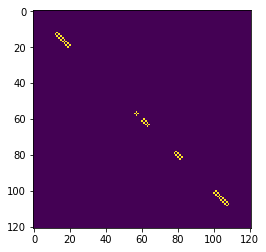

In [20]:
s=(height*width,width*height)
T=np.ones(s)

#Deselecting non-transient states(like wall-to-wall or wall-to-state etc.) and diagonal states which no path is possible
for i in range(width):
    for j in range(height):
        if M[i][j] == 1:
            for m in range(s[0]):
                for n in range(s[1]):
                    T[i*width+j][n]=0
                    T[m][i*width+j]=0
                    modm= m % 2
                    modn= n % 2
                    if modm==modn:
                        T[m][n]=0
    
#Deselecting the neighbors which their indices only change from the current state with +/-1 
for m in range(s[0]):
    for n in range(s[1]):
        if  abs(m-n)!=1:
            T[m][n]=0
plt.imshow(T)

* ## Horizontal Neighbors Matrix

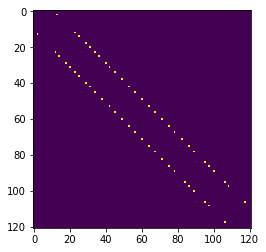

In [21]:
s=(height*width,width*height)
G=np.ones(s)

#Deselecting non-transient states(like wall-to-wall or wall-to-state etc.) and diagonal states which no path is possible
for i in range(width):
    for j in range(height):
        if M[i][j] == 1:
            for m in range(s[0]):
                for n in range(s[1]):
                    G[i*width+j][n]=0
                    G[m][i*width+j]=0
                    modm= m % 2
                    modn= n % 2
                    if modm==modn:
                        G[m][n]=0
    
#Deselecting the neighbors which their indices only change from the current state with +/-(sqrt(M.size)) 
for m in range(s[0]):
    for n in range(s[1]):
        if  abs(m-n)!=np.sqrt(height*width):
            G[m][n]=0
plt.imshow(G)

* ## Diagonal Matrix, creating the self changing state 

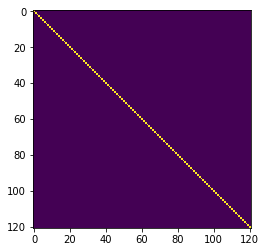

In [22]:
O=np.zeros(s)
for m in range(s[0]):
    for n in range(s[1]):
        if m==n:
            O[m][n]=1
plt.imshow(O)

* ## Adding all matrices together and normalizing rows to P(i)=1

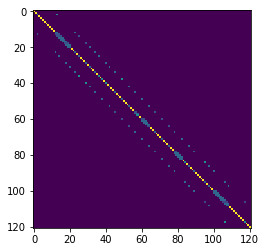

In [23]:
P=T+G+O
for row in range(P.shape[0]):
    P[row] /= np.sum(P[row])
P=np.nan_to_num(P)
plt.imshow(P)
#print(P.sum(axis=1))

## Removing the non-transient states

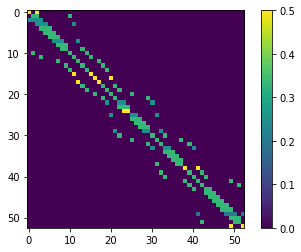

In [24]:
np.place(P, P==1, [0])
bad_rows=np.where(P.sum(axis=1)==0)
bad_cols=np.where(P.sum(axis=0)==0)
P = np.delete(P,bad_rows,axis=0)
P = np.delete(P,bad_cols,axis=1)
plt.imshow(P)
plt.colorbar()

## Estimating a Markov Model with the PyEmma and MSM Tools

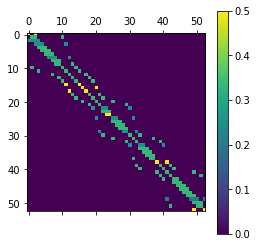

In [25]:
#Estimating the largest connection in the matrix in order to reduce computation time(?)
T=msmtools.estimation.largest_connected_submatrix(P)

#Estimating a discrete-state Markov model
msm = pyemma.msm.markov_model(T)
keptindices = msmtools.estimation.largest_connected_set(P)
plt.matshow(msmtools.estimation.largest_connected_submatrix(P))
plt.colorbar()

C:\Users\Seldon\AppData\Local\conda\conda\envs\py36\lib\site-packages\pyemma\plots\networks.py:74: UserWarning: The layout optimization method will take a long time for large networks! It is recommended to coarse grain your model first!
  warnings.warn("The layout optimization method will take a long"


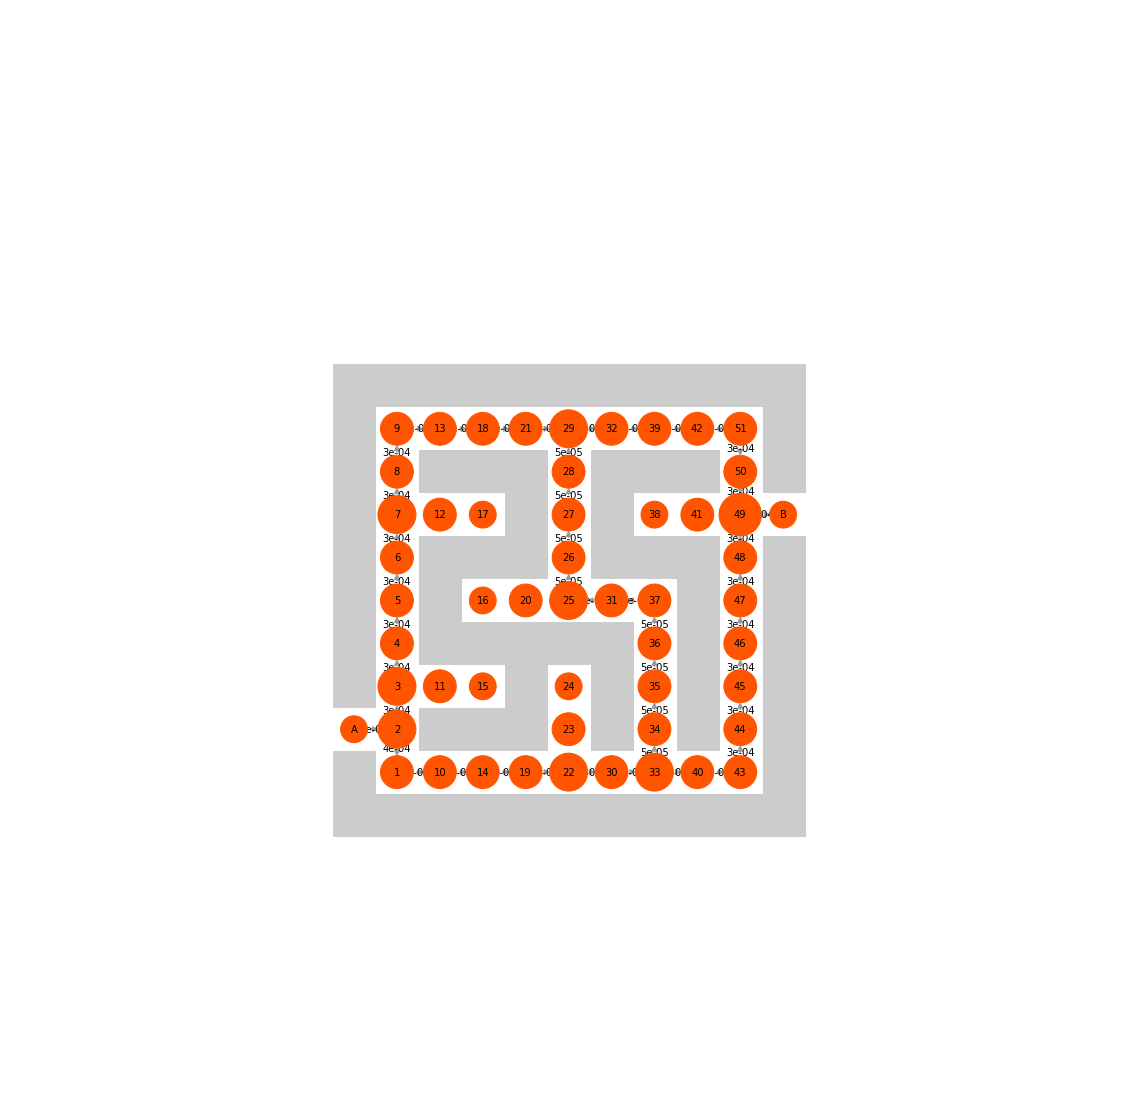

In [26]:
#choosing state A and B
size_M=M.size
non_path=np.count_nonzero(M)
exit=size_M-non_path-1
enter=0

#Reactive Flux from Transition Path Theory
tpt = pyemma.msm.tpt(msm, np.array([enter,enter]), np.array([exit,exit]))

#choosing positions to draw the states on.
path = np.where(M == 0)
pos = np.array(path).T

#Drawing Reactive Flux
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(111)
pyemma.plots.plot_flux(tpt, pos=pos, ax=ax1, arrow_curvature=0, figpadding=.8, max_width=20, max_height=20, show_committor=False);
plt.imshow(M.T, cmap=plt.cm.binary, interpolation='none', origin='lower', alpha=.2)
plt.show()

# Markov Maze

## Question:
Consider an unbiased random walk in a maze with one entry and one exit.
Find a way to generate a maze and to represent the random walk in it as a
transition matrix. Compute the committor _entry_ $\rightarrow$ _exit_ and the reactive ux.
Represent your results graphically.

## Answer:
In order to create a maze, we execute a maze generation algorithm. This algorithm ensures that an $nxn$ maze created as a matrix and all related variables as paths,entry,exit,walls etc. created randomly. The created maze should not contain double walls or paths, which ensures that all the created mazes have an odd number of size lie $3x3$,$17x17$ etc. This will be an important property because it effects how we create our transition matrix.

In order to 